# Values text comparison
Cycle 7. Oct 2025

Different methods:
- Tfidf
- Embeddings
    - OpenAI embeddings API

In [ ]:
import sys
print(sys.executable)

/Users/alejandranavarrocastillo/.pyenv/versions/3.10.13/bin/python


In [2]:
# Imports
import numpy as np
from numpy.linalg import norm

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# User class to hold responses and embeddings
class User:
    def __init__(self, id, togetherness, genuine_individuality, serve_humanity, wellbeing, designer):
        self.id = id
        self.responses = {
            "togetherness": togetherness,
            "genuine_individuality": genuine_individuality,
            "serve_humanity": serve_humanity,
            "wellbeing": wellbeing,
            "designer": designer
        }
        self.embeddings = {}

In [4]:
# Mock users
alice = User(1, "Community is about supporting and growing together.",
                "Being authentic means honesty and curiosity.",
                "I try to serve humanity through empathy and volunteering.",
                "Health is about balance between mind and body.",
                "Fulfillment comes from creating meaningful work.")

bob = User(2, "A good community helps each other and celebrates differences.",
               "Being myself means being honest about my needs and passions.",
               "Serving others gives me purpose.",
               "I care deeply about emotional and mental well-being.",
               "I want to design a life where my creativity helps others.")

carol = User(3, "Building strong connections through shared experiences.",
                "Authenticity is about staying true to your values.",
                "Making a positive impact through small daily actions.",
                "Wellness comes from nurturing both spirit and body.",
                "Design should enhance human connection and joy.")

david = User(4, "Community thrives on mutual respect and understanding.",
                "Being genuine means embracing your flaws and strengths.",
                "Contributing to society through innovation and teaching.",
                "Health includes social and environmental wellbeing.",
                "Creating spaces that inspire and unite people.")

emma = User(5, "Fostering inclusivity and meaningful relationships.",
               "Authenticity requires courage and self-reflection.",
               "Helping others through sustainable initiatives.",
               "Balancing personal growth with physical health.",
               "Designing solutions for community challenges.")

frank = User(6, "Creating safe spaces for diverse perspectives.",
                "Living truthfully and expressing oneself freely.",
                "Supporting local communities and global causes.",
                "Practicing mindfulness and active self-care.",
                "Using design thinking to solve social problems.")

grace = User(7, "Building bridges between different cultures.",
                "Staying genuine in face of social pressure.",
                "Volunteering and sharing knowledge with others.",
                "Finding harmony in work-life balance.",
                "Creating meaningful experiences through design.")

henry = User(8, "Nurturing relationships through active listening.",
                "Being real and vulnerable with others.",
                "Making the world better through small changes.",
                "Prioritizing mental and emotional health.",
                "Designing sustainable solutions for tomorrow.")

## Tf-idf

In [5]:
# Tf-idf vectorizer
def vectorize_text_tfidf(users):
    vectorizer = TfidfVectorizer()
    similarities = {}

    # Iterate through each category
    for category in users[0].responses.keys():
        # Collect texts from all users for the current category
        texts = [user.responses[category] for user in users]
        tfidf_matrix = vectorizer.fit_transform(texts)

        # Convert to dense arrays
        dense_matrix = tfidf_matrix.todense()

        # Calculate cosine similarities between the first user and others
        vec1 = dense_matrix[0]
        for i in range(1, len(users)):
            vec2 = dense_matrix[i]
            similarity = np.dot(vec1, vec2.T) / (norm(vec1) * norm(vec2))
            similarities[(users[0].id, users[i].id)] = float(similarity)

    return similarities

# Test TF-IDF vectorization with all users
users = [alice, bob, carol, david, emma, frank, grace, henry]
similarities = vectorize_text_tfidf(users)
print("TF-IDF Similarities:")
for (id1, id2), score in similarities.items():
    print(f"User {id1} and User {id2}: {score:.3f}")

TF-IDF Similarities:
User 1 and User 2: 0.000
User 1 and User 3: 0.000
User 1 and User 4: 0.092
User 1 and User 5: 0.000
User 1 and User 6: 0.000
User 1 and User 7: 0.281
User 1 and User 8: 0.000


/var/folders/gh/3hwvv_x974j73pl2v_j8z7380000gn/T/ipykernel_11345/130980571.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[(users[0].id, users[i].id)] = float(similarity)


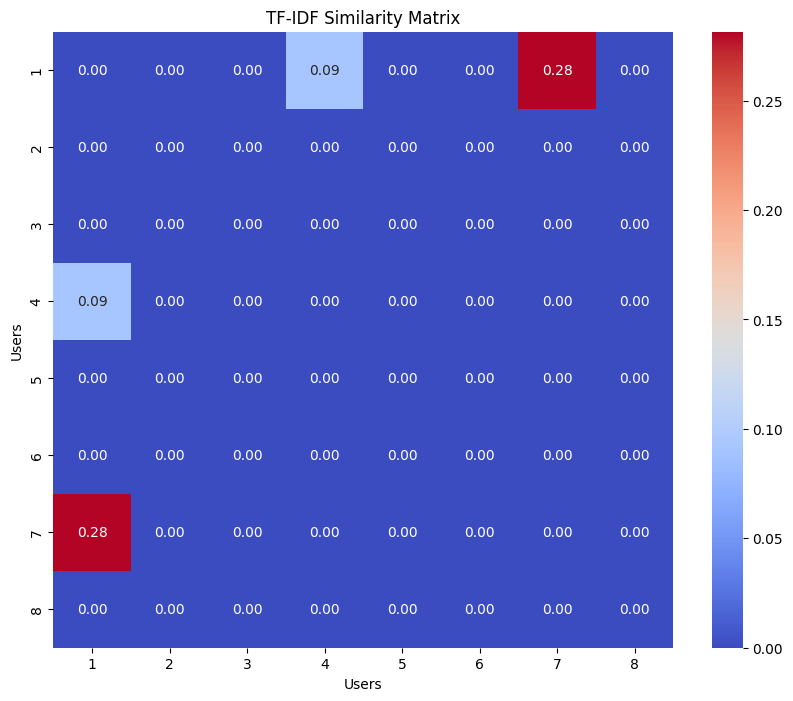

In [6]:
# Create a colorful matrix of similarities
def plot_similarity_matrix(similarities, user_ids):
    matrix = np.zeros((len(user_ids), len(user_ids)))

    for (id1, id2), score in similarities.items():
        idx1 = user_ids.index(id1)
        idx2 = user_ids.index(id2)
        matrix[idx1, idx2] = score
        matrix[idx2, idx1] = score  # Symmetric matrix

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=user_ids, yticklabels=user_ids)
    plt.title("TF-IDF Similarity Matrix")
    plt.xlabel("Users")
    plt.ylabel("Users")
    plt.show()

# Test the similarity matrix plotting
user_ids = [user.id for user in users]
plot_similarity_matrix(similarities, user_ids)

## Embeddings

In [9]:
!pip install openai --quiet
from openai import OpenAI
import numpy as np

client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text
    )
    return np.array(response.data[0].embedding)

def embed_user(user):
    for key, text in user.responses.items():
        user.embeddings[key] = get_embedding(text)
    return user


zsh:1: /Users/alejandranavarrocastillo/Documents/GitHub/glasshome-matching-colivers/.venv/bin/pip: bad interpreter: /Users/alejandranavarrocastillo/Documents/GitHub/glasshome-matching-colivers/venv/bin/python: no such file or directory

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/alejandranavarrocastillo/.pyenv/versions/3.10.13/bin/python3.10 -m pip install --upgrade pip


ModuleNotFoundError: No module named 'openai'

In [10]:
# Compute similarity between two users

def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

def compatibility_score(user1, user2, weights=None):
    if weights is None:
        weights = {k: 1/5 for k in user1.embeddings.keys()}

    score = 0
    for category in user1.embeddings.keys():
        s = cosine_similarity(user1.embeddings[category], user2.embeddings[category])
        score += weights[category] * s
    return score


In [11]:
# Example usage

# Generate embeddings
alice = embed_user(alice)
bob = embed_user(bob)

# Compute similarity
score = compatibility_score(alice, bob)
print(f"Compatibility between Alice and Bob: {score:.3f}")


NameError: name 'embed_user' is not defined

## Moral Foundations BERT
https://github.com/lorenzozangari/ME2-BERT/blob/master/me2bert_example.ipynb

Notes:
model(**inputs) 
this is equivalent to 
model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "lorenzozan/ME2-BERT"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
users = [alice, bob, carol, david, emma, frank, grace, henry]
for category in users[0].responses.keys():
    # Collect texts from all users for the current category
    texts = [user.responses[category] for user in users]

inputs = tokenizer(texts, padding="max_length", truncation=True, return_tensors="pt")
model.eval()  # optional but best practice
with torch.no_grad():
    outputs = model(**inputs, return_dict=True)

print(outputs) # tensor([[0.0185, 0.2401, 0.9166, 0.0498, 0.0453]])
# {'CH':'CARE/HARM','FC':'FAIRNESS/CHEATING', 'LB':'LOYALTY/BETRAYAL', 'AS':'AUTHORITY/SUBVERSION', 'PD': 'PURITY/DEGRADATION'}

[{'CH': 0.05056, 'FC': 0.01845, 'LB': 0.8676, 'AS': 0.01655, 'PD': 0.06524}]


## Deberta Human Value Detector

In [3]:

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

tokenizer =  AutoTokenizer.from_pretrained("tum-nlp/Deberta_Human_Value_Detector")
trained_model = AutoModelForSequenceClassification.from_pretrained("tum-nlp/Deberta_Human_Value_Detector", trust_remote_code=True)

example_text ='We should ban whaling because whales are a species at the risk of distinction'

encoding = tokenizer.encode_plus(
        example_text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt',
    )

with torch.no_grad():
        test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
        test_prediction = test_prediction["output"].flatten().numpy()


/Users/alejandranavarrocastillo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of the following files was downloaded from https://huggingface.co/tum-nlp/Deberta_Human_Value_Detector:
- configuration_deberta_arg_classifier.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/tum-nlp/Deberta_Human_Value_Detector:
- modeling_deberta_arg_classifier.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434